In [1]:
RAND_STATE = 42

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("../saved/final_dataset_cs_papers_last_20.csv", index_col='PaperId')

In [154]:
df = df[df["YearsSincePublication"] > 10]
df.shape[0]

27488

In [155]:
normalized_cc = df["CitationCountPerYear"].values
normalized_cc.shape

(27488,)

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns

def correlation(df, columns=None, plot=True):
    t = df[columns] if columns else df
    if not plot:
        print(t.corr())
    else:
        fig = plt.figure(figsize=(12, 12), dpi=120)
        mask = np.triu(t.corr())
        sns.heatmap(
            t.corr(),
            mask=mask,
            cbar=False,
            square=True,
            annot=True,
            vmin=-1,
            vmax=1,
            center=0,
            cmap="coolwarm_r",
            linecolor="black",
        )
        
        plt.show()

In [160]:
print("Number of Authors")
print(df["NumberOfAuthors"].mean())
print(df["NumberOfAuthors"].max())
print(df["NumberOfAuthors"].min())

Number of Authors
2.7264624563445867
9
1


In [161]:
def add_number_of_authors_feature(doc):
    author_cols = doc.index.str.startswith("Author_")
    author_ids = doc[author_cols][pd.notnull(doc[author_cols])]
    return len(author_ids)

df["NumberOfAuthors"] = df.apply(add_number_of_authors_feature, axis=1)



In [162]:
print(f"Max number of citations per year: {np.max(normalized_cc)}")
print(f"Median number of citations per year: {np.median(normalized_cc)}")
print(f"Mean number of citations per year: {np.mean(normalized_cc)}")
print(f"Std number of citations per year: {np.std(normalized_cc)}")

print(f"Number of papers with 0 citations: {np.sum((normalized_cc == 0))}")
print(f"Number papers with over 1 citation per year: {np.sum(normalized_cc > 1)}")
print(f"Number papers with over 5 citations per year: {np.sum(normalized_cc > 5)}")
print(f"Number papers with over 25 citations per year: {np.sum(normalized_cc > 25)}")
print(f"Number papers with over 100 citations per year: {np.sum(normalized_cc > 100)}")
print(f"Number papers with over 1k citations per year: {np.sum(normalized_cc > 1000)}")


Max number of citations per year: 1143.3305548940225
Median number of citations per year: 0.7338794535294431
Mean number of citations per year: 3.787977073841506
Std number of citations per year: 17.081205482158058
Number of papers with 0 citations: 3184
Number papers with over 1 citation per year: 11709
Number papers with over 5 citations per year: 4847
Number papers with over 25 citations per year: 606
Number papers with over 100 citations per year: 88
Number papers with over 1k citations per year: 1


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fd731e67fa0>,
                 k=None, locate_elbow=True, metric='distortion', model=None,
                 timings=True)

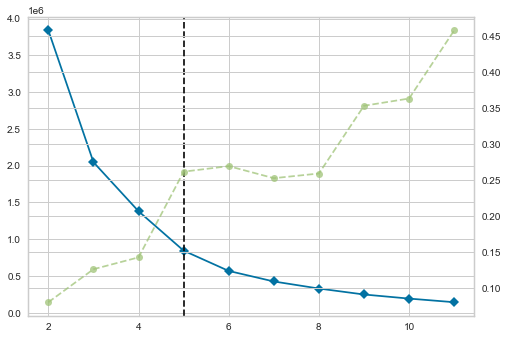

In [163]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))
visualizer.fit(normalized_cc.reshape(-1, 1))

In [164]:
clstr = KMeans(n_clusters=4, random_state=0)
clstr.fit(normalized_cc.reshape(-1,1))
clstr.cluster_centers_

array([[  2.48872365],
       [273.18977189],
       [836.50650209],
       [ 61.06486267]])

In [165]:
from sklearn.mixture import GaussianMixture as GMM
gmm = GMM(n_components=4, random_state=0)
gmm.fit(normalized_cc.reshape(-1,1))
gmm.means_

array([[  0.49405761],
       [105.77133491],
       [ 17.5224541 ],
       [  4.67796546]])

In [166]:
def custom_binning(x, thresholds):
    thresholds = thresholds.copy()
    thresholds.sort()
    for i, threshold in enumerate(thresholds):
        if (x <= threshold):
            return i + 1

    return len(thresholds)


In [167]:
thresholds = np.array([mu + np.sqrt(var).round() for mu, var in zip(gmm.means_, gmm.covariances_)]).flatten()
thresholds.sort()
n_classes = len(thresholds)
print(thresholds)
df["BinnedCitations"] = pd.Series([custom_binning(x, thresholds) for x in normalized_cc], index=df.index)
df.head()

[  0.49405761   7.67796546  26.5224541  225.77133491]


,Abstract,Author_1,Author_10,Author_11,Author_2,Author_3,Author_4,Author_5,Author_6,Author_7,...,AuthorRank,JournalNameRank,PublisherRank,PageCount,Processed_Abstract,JournalNameRankNormalized,PublisherRankNormalized,BinnedCitations,NumberOfAuthors,PublicationMonth
PaperId,,,,,,,,,,,,,,,,,,,,,
2147483970,This paper deals with an application of wavele...,2275778229,NaN,NaN,2.779769e+09,1.355326e+09,2.095098e+09,NaN,NaN,NaN,...,128.0,993.0,624.0,14.0,this paper deal application wavelet feature ex...,888.0,363.0,1,4,12
2013266260,An object-to-object color mapping method based...,2135137024,NaN,NaN,2.131763e+09,2.106423e+09,NaN,NaN,NaN,NaN,...,127.0,759.0,585.0,10.0,an object object color map method base image s...,624.0,303.0,1,3,1
2013267625,Due to recent developments in pervasive and ub...,2043862696,NaN,NaN,2.145587e+09,1.753179e+08,2.644881e+09,NaN,NaN,NaN,...,639.0,89.0,546.0,0.0,due recent development pervasive ubiquitous co...,708.0,255.0,1,4,1
1879050372,Object-oriented NeuroSys is a collection of pr...,2616740025,NaN,NaN,2.444026e+09,2.477150e+09,2.496861e+09,2.806679e+09,NaN,NaN,...,1.0,993.0,624.0,9.0,object orient neurosys collection program simu...,888.0,363.0,1,5,9
2013268558,"Since the web is always developing, and users'...",1212249664,NaN,NaN,2.151053e+09,NaN,NaN,NaN,NaN,NaN,...,13.0,858.0,455.0,9.0,since web develope user need constantly change...,1082.0,351.0,2,2,1


[11419, 13047, 2463, 559]


([<matplotlib.axis.XTick at 0x7fd7b62fb880>,
 <a list of 4 Text major ticklabel objects>)

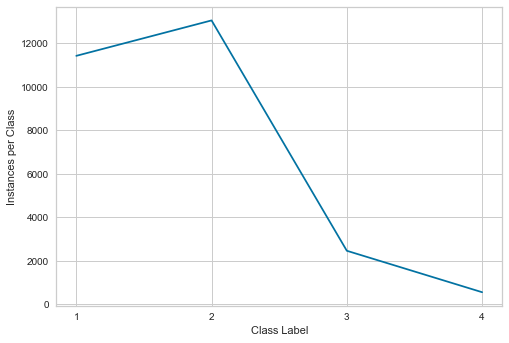

In [168]:
import matplotlib.pyplot as plt
import seaborn as sns

classes = list(range(1, 1 + n_classes))

x = [np.sum(df.loc[:, "BinnedCitations"].values == c) for c in classes]
print(x)
fig = plt.figure()
plt.plot(classes, x)
plt.ylabel("Instances per Class")
plt.xlabel("Class Label")
plt.xticks(classes)

## Convert to binary classification

In [182]:
classes = [0, 1]
n_classes = 2

#df["BinnedCitations"][df["BinnedCitations"] == 1] = 0
#df["BinnedCitations"][df["BinnedCitations"] == 2] = 1
#df["BinnedCitations"][df["BinnedCitations"] == 3] = 1
#df["BinnedCitations"][df["BinnedCitations"] == 4] = 1
df["BinnedCitations"][df["CitationCountPerYear"] < 5] = 0
df["BinnedCitations"][df["CitationCountPerYear"] >= 5] = 1

[22641, 4847] [0, 1]


([<matplotlib.axis.XTick at 0x7fd762297fa0>,
 <a list of 2 Text major ticklabel objects>)

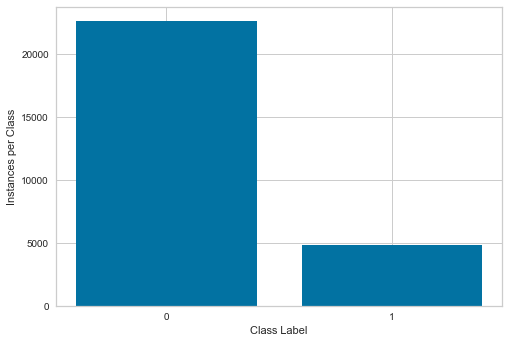

In [183]:
x = [np.sum(df.loc[:, "BinnedCitations"].values == c) for c in classes]
print(x, classes)
fig = plt.figure()
plt.bar(classes, x)
plt.ylabel("Instances per Class")
plt.xlabel("Class Label")
plt.xticks(classes)

In [184]:
from sklearn.metrics import classification_report
features = [ 
    "AuthorProminence",
    "JournalNameRankNormalized",
    "PublisherRankNormalized",
    "AuthorRank",
    "PageCount",
    #"PublicationMonth",
    #"NumberOfAuthors"
    ]
X = df.loc[:, features]
y = df.loc[:, "BinnedCitations"]

print(X.shape, y.shape)
print(classification_report(y, y))


(27488, 5) (27488,)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22641
           1       1.00      1.00      1.00      4847

    accuracy                           1.00     27488
   macro avg       1.00      1.00      1.00     27488
weighted avg       1.00      1.00      1.00     27488



# Data split into train, test, and dev

In [185]:
from sklearn.model_selection import train_test_split
X, X_test, y, y_test = train_test_split(X, y, test_size=0.10, shuffle=True, random_state=RAND_STATE)

X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RAND_STATE)

print(X_train.shape)
print(X_dev.shape)
print(X_test.shape)

(21028, 5)
(3711, 5)
(2749, 5)


In [186]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=RAND_STATE, n_estimators=1000, max_depth=3, learning_rate=0.01, min_child_weight=3)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [187]:
from sklearn.metrics import confusion_matrix

y_true = y_dev
y_pred = xgb.predict(X_dev)

print(confusion_matrix(y_true, y_pred, labels=classes))
print(classification_report(y_true, y_pred))
print("Train performance")
print(xgb.score(X_train, y_train))
print("Dev performance")
print(xgb.score(X_dev, y_dev))

[[2936   90]
 [ 552  133]]
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      3026
           1       0.60      0.19      0.29       685

    accuracy                           0.83      3711
   macro avg       0.72      0.58      0.60      3711
weighted avg       0.80      0.83      0.79      3711

Train performance
0.8422103861517976
Dev performance
0.8270008084074374


In [188]:
def df_from_predictions(paper_ids, y_pred, original_df):
    pred_df = pd.DataFrame(
        list(zip(paper_ids, y_pred)),
        columns=["PaperId", "PredictedBinnedCitations"]
    ).set_index("PaperId")
    pred_df = pred_df.join(original_df, on='PaperId')
    pred_df["Misclassified"] = pred_df.apply(lambda x: 1 if x["PredictedBinnedCitations"] != x["BinnedCitations"] else 0, axis=1)
    pred_df["MisclassifiedAsHigh"] = pred_df.apply(
        lambda x: 1 if x["PredictedBinnedCitations"] and x["Misclassified"] else 0, 
        axis=1
    )
    pred_df["MisclassifiedAsLow"] = pred_df.apply(
        lambda x: 1 if x["PredictedBinnedCitations"]== 0 and x["Misclassified"] else 0, 
        axis=1
    )

    return pred_df

train_predictions_df = df_from_predictions(X_train.index, xgb.predict(X_train), df)

In [189]:
train_predictions_df.to_csv("../saved/xgb_predictions_train2.csv", index_label="PaperId")